The idea in one sentence: Use gradient updates to understand what neurons in a transformer are responsible for.

We can backprop on a run of GPT-2 over an input like "The Eiffel Tower is located in Paris." or 
"The Eiffel Tower is located in Rome." to see which neurons such an input would update. Or, the focus
here, we look at the difference between the two updates to see what changes as a result of the Eiffel
Tower being located in Rome, rather than Paris (this is primarily intended to negate distributional shift).

## Setup

Not too interesting:
* Set up some example prompts
* Run backprop over them
* Put everything in a dataframe to look at in the other sections.

In [1]:
from transformer_lens import HookedTransformer
import numpy as np
import pandas as pd
from typing import List, Union, Literal, Tuple
import plotly.express as px
import plotly.io as pio
import plotly.graph_objs as go
pio.renderers.default = "png"

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = HookedTransformer.from_pretrained("gpt2-small", device="cpu")
# model.cfg.use_attn_result = True

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-small into HookedTransformer


In [3]:
x = np.arange(12)
top_N = 20

In [4]:
# For simplicity we're going to look at only neuron weights, no biases.
posns = [
#     'W_Q',
#     'b_Q',
#     'W_K',
#     'b_K',
#     'W_V',
#     'b_V',
#     'W_O',
#     'b_O',
    'W_in',
#     'b_in',
    'W_out',
#     'b_out',
]

In [5]:
Row = Tuple[str, str, str, Union[Literal["W_in"], Literal["W_out"]], int, np.ndarray]

In [6]:
def eval_prompt(prompt_base: str, supposed_answer: str, actual_answer: str) -> List[Row]:
    loss = model(f"{prompt_base} {supposed_answer}.", return_type="loss")
    loss.backward()
    rows = []
    for i in range(len(model.blocks)):
        for posn in posns:
            rows.append((prompt_base, supposed_answer, actual_answer, posn, i, getattr(model.blocks[i].mlp, posn).grad.clone().numpy()))
    model.zero_grad()
    return rows

def eval_prompts(prompt_bases: List[str], supposed_answers: List[str], actual_answer: str) -> List[Row]:
    rows = []
    for prompt_base in prompt_bases:
        for supposed_answer in supposed_answers:
            rows.extend(eval_prompt(prompt_base, supposed_answer, actual_answer))
    return rows

In [7]:
# Note: some prompts / cities are commented out because my kernel was using too much memory and dying.
eiffel_bases = [
    "The Eiffel Tower is located in", 
    "The site of the Eiffel Tower,",
    "The construction of the Eiffel Tower started in 1887 in,",
]

# cities = ["Paris", "Rome", "Madrid", "Tokyo", "London", "New York", "Beijing", "San Francisco", "Melbourne"]
cities = ["Paris", "Rome", "Tokyo", "Beijing", "Melbourne"]

# Prompts that evoke Paris but aren't about the Eiffel Tower
paris_bases = [
    "The capital of France is",
    "The largest city in France,",
    "The city known as the City of Lights is",
    "The birthplace of the French Revolution is",
    "Famous for its picturesque Seine River,",
    "Home to the renowned Louvre Museum,",
    "The setting of Victor Hugo's novel The Hunchback of Notre-Dame,",
    # "The city where the famous Notre-Dame Cathedral can be found is",
]

rome_bases = [
    "The capital of Italy is",
    "The largest city in Italy,",
    "The city known as the Eternal City is",
    "The birthplace of the Roman Empire is",
    "Famous for its picturesque Tiber River,",
    "Home to the renowned Colosseum,",
    # "Where you can find the Vatican City,",
    "A city boasting the famous Spanish Steps,",
]


In [8]:
base_rows = []
base_rows.extend(eval_prompts(eiffel_bases, cities, "Paris"))

In [9]:
base_rows.extend(eval_prompts(paris_bases, cities, "Paris"))

In [10]:
base_rows.extend(eval_prompts(rome_bases, cities, "Rome"))

In [11]:
base_columns = ["Base", "Given Answer", "Correct Answer", "Matrix", "Layer", "Gradient"]
base_df = pd.DataFrame(base_rows, columns=base_columns).set_index(["Base", "Given Answer", "Correct Answer", "Matrix", "Layer"])

In [12]:
grad = base_df.loc[("The Eiffel Tower is located in", "Rome", "Paris", "W_in", 1), "Gradient"]
grad.shape

(768, 3072)

In [13]:
base_df.size

2040

In [14]:
diff_rows = []
for base in eiffel_bases + paris_bases:
    for city in cities:
        if city == "Paris":
            continue
        for layer in range(12):
            for matrix in ["W_in", "W_out"]:
                diff_rows.append((
                    base, city, "Paris", matrix, layer, 
                    base_df.loc[(base, city,    "Paris", matrix, layer), "Gradient"] - 
                    base_df.loc[(base, "Paris", "Paris", matrix, layer), "Gradient"]
                ))
        
for base in rome_bases:
    for city in cities:
        if city == "Rome":
            continue
        for layer in range(12):
            for matrix in ["W_in", "W_out"]:
                diff_rows.append((
                    base, city, "Rome", matrix, layer, 
                    base_df.loc[(base, city,   "Rome", matrix, layer), "Gradient"] - 
                    base_df.loc[(base, "Rome", "Rome", matrix, layer), "Gradient"]
                ))
        
diff_columns = ["Base", "Given Answer", "Correct Answer", "Matrix", "Layer", "Gradient"]
diff_df = pd.DataFrame(diff_rows, columns=diff_columns).set_index(["Base", "Given Answer", "Correct Answer", "Matrix", "Layer"])

## Layers

This is most interesting as a point of comparison with Does Localization Inform Editing? (https://arxiv.org/abs/2301.04213).
Our results agree with theirs in that we see updates over all layers, rather than localized to one or two.

(I think it's generally more interesting to examine individual neurons, below)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


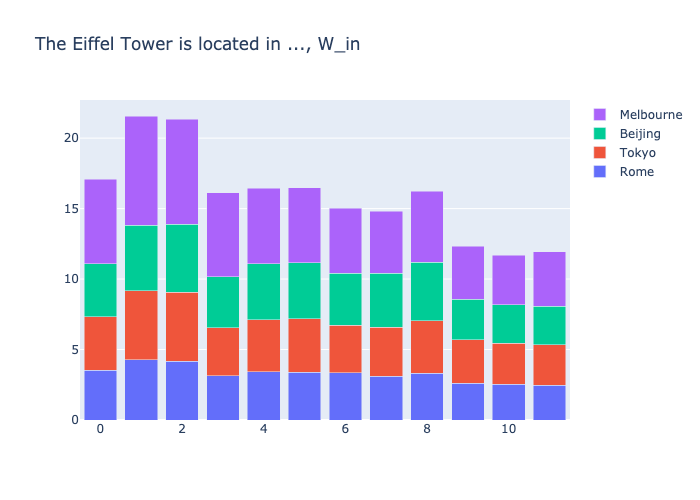

In [15]:
fig = go.Figure(data=[
    go.Bar(name=cities[i], x=x, y=[
      np.linalg.norm(diff_df.loc[(eiffel_bases[0], cities[i], "Paris", "W_in", layer), "Gradient"])
      for layer in range(12)])
    for i in range(1, len(cities))
])
fig.update_layout(
    barmode='stack',
    title=f'{eiffel_bases[0]} ..., W_in',
)
fig.show()

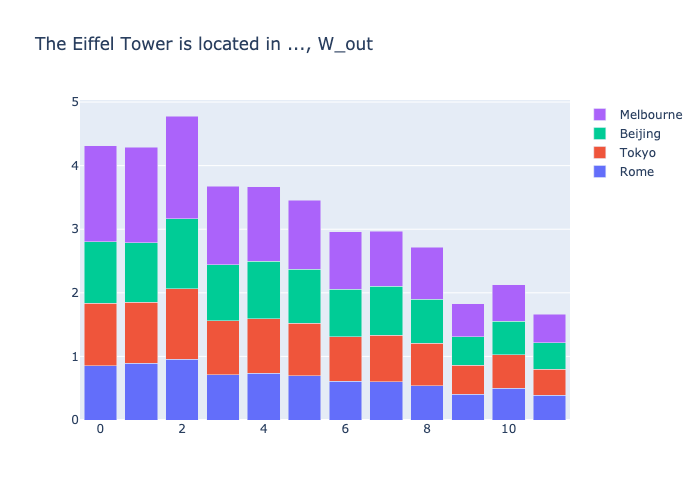

In [16]:
fig = go.Figure(data=[
    go.Bar(name=cities[i], x=x, y=[
      np.linalg.norm(diff_df.loc[(eiffel_bases[0], cities[i], "Paris", "W_out", layer), "Gradient"])
      for layer in range(12)])
    for i in range(1, len(cities))
])
fig.update_layout(
    barmode='stack',
    title=f'{eiffel_bases[0]} ..., W_out',
)
fig.show()

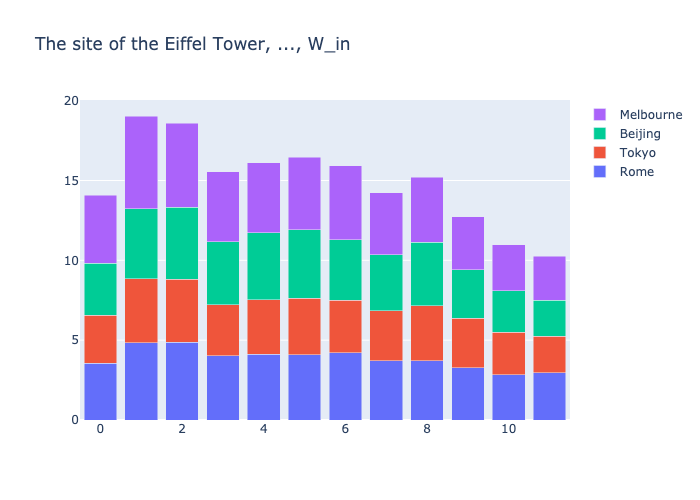

In [17]:
fig = go.Figure(data=[
    go.Bar(name=cities[i], x=x, y=[
      np.linalg.norm(
        diff_df.loc[(eiffel_bases[1], cities[i], "Paris", "W_in", layer), "Gradient"]
      )
      for layer in range(12)])
    for i in range(1, len(cities))
])
fig.update_layout(
    barmode='stack',
    title=f'{eiffel_bases[1]} ..., W_in',
)
fig.show()

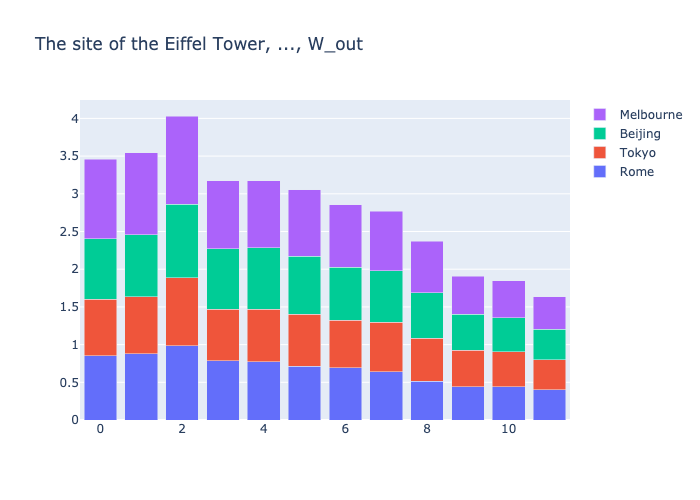

In [18]:
fig = go.Figure(data=[
    go.Bar(name=cities[i], x=x, y=[
      np.linalg.norm(diff_df.loc[(eiffel_bases[1], cities[i], "Paris", "W_out", layer), "Gradient"])
      for layer in range(12)])
    for i in range(1, len(cities))
])
fig.update_layout(
    barmode='stack',
    title=f'{eiffel_bases[1]} ..., W_out',
)
fig.show()

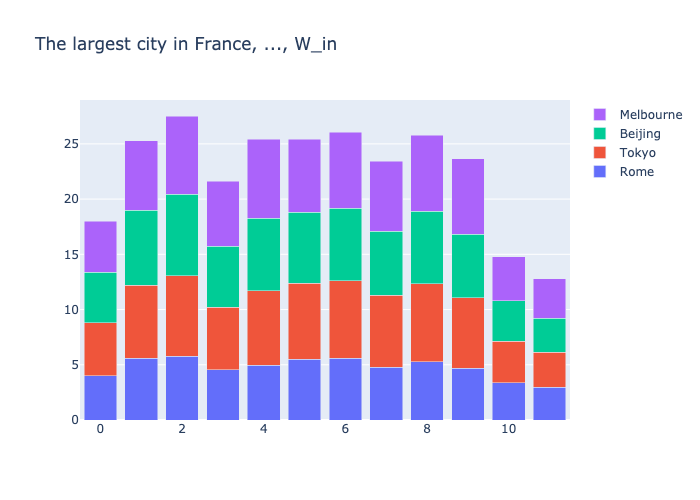

In [19]:
fig = go.Figure(data=[
    go.Bar(name=cities[i], x=x, y=[
      np.linalg.norm(diff_df.loc[(paris_bases[1], cities[i], "Paris", "W_in", layer), "Gradient"])
      for layer in range(12)])
    for i in range(1, len(cities))
])
fig.update_layout(
    barmode='stack',
    title=f'{paris_bases[1]} ..., W_in',
)
fig.show()

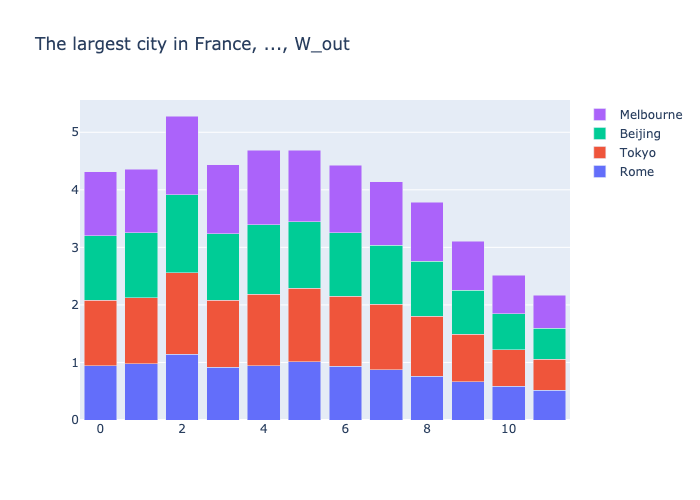

In [20]:
fig = go.Figure(data=[
    go.Bar(name=cities[i], x=x, y=[
      np.linalg.norm(diff_df.loc[(paris_bases[1], cities[i], "Paris", "W_out", layer), "Gradient"])
      for layer in range(12)])
    for i in range(1, len(cities))
])
fig.update_layout(
    barmode='stack',
    title=f'{paris_bases[1]} ..., W_out',
)
fig.show()

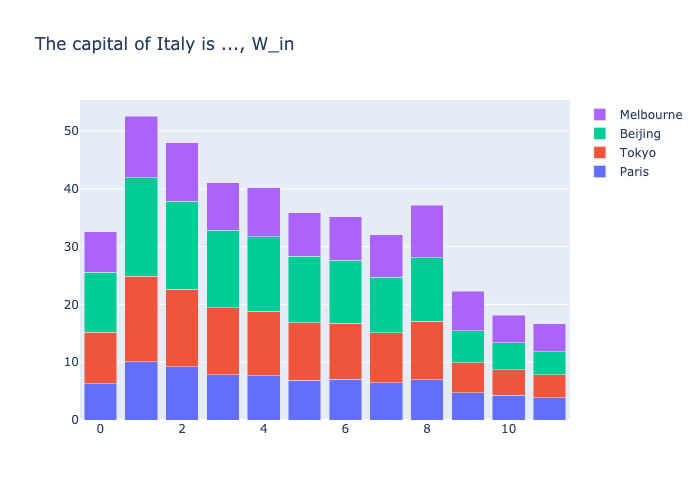

In [21]:
fig = go.Figure(data=[
    go.Bar(name=cities[i], x=x, y=[
      np.linalg.norm(diff_df.loc[(rome_bases[0], cities[i], "Rome", "W_in", layer), "Gradient"])
      for layer in range(12)])
    for i in range(len(cities)) if i != 1
])
fig.update_layout(
    barmode='stack',
    title=f'{rome_bases[0]} ..., W_in',
)
fig.show()

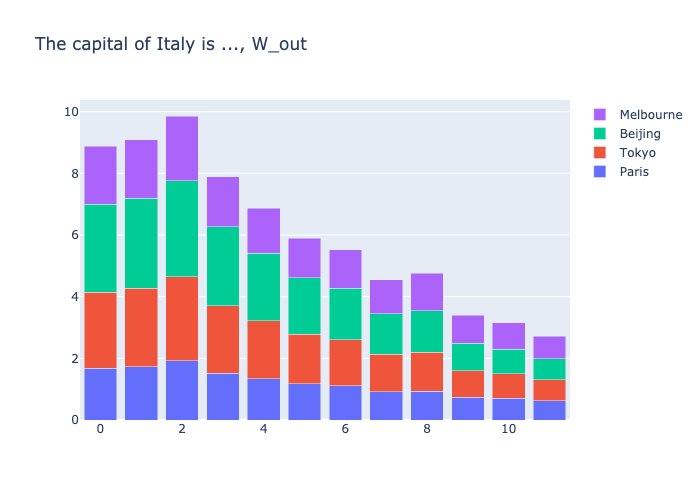

In [22]:
fig = go.Figure(data=[
    go.Bar(name=cities[i], x=x, y=[
      np.linalg.norm(diff_df.loc[(rome_bases[0], cities[i], "Rome", "W_out", layer), "Gradient"])
      for layer in range(12)])
    for i in range(len(cities)) if i != 1
])
fig.update_layout(
    barmode='stack',
    title=f'{rome_bases[0]} ..., W_out',
)
fig.show()

## Neurons

Can we localize changes to individual neurons?

In [23]:
rows2 = []
for (prompt_base, given_answer, correct_answer, matrix, layer), grad in diff_df["Gradient"].items():
  neuron_axis = 0 if matrix == 'W_in' else 1
  for neuron, magnitude in enumerate(np.linalg.norm(grad, axis=neuron_axis)):
    rows2.append((prompt_base, given_answer, correct_answer, matrix, layer, neuron, magnitude))
    
columns = ["Base", "Given Answer", "Correct Answer", "Matrix", "Layer", "Neuron", "Magnitude"]
diff_df2 = pd.DataFrame(rows2, columns=columns).set_index(["Base", "Given Answer", "Correct Answer", "Matrix", "Layer", "Neuron"])

In [24]:
diff_df2.size

5013504

TODO: add histograms to show magnitudes of change
TODO: it turns out that only W_in shows up in all of these. Look at W_out as well!

In [25]:
print(f'Top {top_N} neurons with the highest magnitude of change away from Paris')
diff_df2 \
  .loc[(slice(None), slice(None), "Paris", slice(None), slice(None), slice(None)), :] \
  .sort_values(by="Magnitude", ascending=False).head(top_N)

Top 20 neurons with the highest magnitude of change away from Paris


Magnitude
Base                                       Given Answer Correct Answer Matrix Layer Neuron           
The city known as the City of Lights is    Melbourne    Paris          W_in   11    369      3.498796
                                           Tokyo        Paris          W_in   11    369      3.428604
The birthplace of the French Revolution is Tokyo        Paris          W_in   8     1961     3.424025
The city known as the City of Lights is    Beijing      Paris          W_in   11    369      3.323885
The capital of France is                   Tokyo        Paris          W_in   7     1137     3.304254
                                                                              4     1406     3.257752
The birthplace of the French Revolution is Tokyo        Paris          W_in   7     1137     3.054942
The capital of France is                   Beijing      Paris          W_in   4     1406     2.982404
The birthplace of the French Revolution is Beijing      Paris          W_in   8     1961     2.978161
The capital of France is                   Beijing      Paris          W_in   7     1137     2.952579
The birthplace of the French Revolution is Tokyo        Paris          W_in   8     428      2.895690
The capital of France is                   Tokyo        Paris          W_in   8     1961     2.869446
The city known as the City of Lights is    Rome         Paris          W_in   11    369      2.818926
The capital of France is                   Beijing      Paris          W_in   8     641      2.810137
                                           Tokyo        Paris          W_in   8     428      2.790907
                                                                                    641      2.788456
                                           Melbourne    Paris          W_in   9     1090     2.751420
                                           Beijing      Paris          W_in   8     1961     2.727926
                                                                                    428      2.706186
The largest city in France,                Tokyo        Paris          W_in   9     1503     2.649649

In [26]:
print(f'L11N369 top changes')
diff_df2 \
    .loc[(slice(None), slice(None), slice(None), slice(None), 11, 369), :] \
    .sort_values(by="Magnitude", ascending=False).head(20)

L11N369 top changes


Magnitude
Base                                      Given Answer Correct Answer Matrix Layer Neuron           
The city known as the City of Lights is   Melbourne    Paris          W_in   11    369      3.498796
                                          Tokyo        Paris          W_in   11    369      3.428604
                                          Beijing      Paris          W_in   11    369      3.323885
                                          Rome         Paris          W_in   11    369      2.818926
The Eiffel Tower is located in            Melbourne    Paris          W_in   11    369      2.539692
The city known as the Eternal City is     Paris        Rome           W_in   11    369      2.374645
A city boasting the famous Spanish Steps, Paris        Rome           W_in   11    369      2.303016
Home to the renowned Louvre Museum,       Melbourne    Paris          W_in   11    369      1.873592
                                          Rome         Paris          W_in   11    369      1.762435
The site of the Eiffel Tower,             Rome         Paris          W_in   11    369      1.667901
The city known as the Eternal City is     Melbourne    Rome           W_in   11    369      1.526579
The site of the Eiffel Tower,             Melbourne    Paris          W_in   11    369      1.309075
The Eiffel Tower is located in            Tokyo        Paris          W_in   11    369      1.220182
Home to the renowned Louvre Museum,       Tokyo        Paris          W_in   11    369      1.200963
Home to the renowned Colosseum,           Paris        Rome           W_in   11    369      1.179559
The Eiffel Tower is located in            Beijing      Paris          W_in   11    369      1.171129
The city known as the Eternal City is     Beijing      Rome           W_in   11    369      1.154771
Famous for its picturesque Seine River,   Melbourne    Paris          W_in   11    369      1.139496
The city known as the Eternal City is     Tokyo        Rome           W_in   11    369      1.089409
Famous for its picturesque Tiber River,   Paris        Rome           W_in   11    369      1.088506

L11N369 cares a lot about Paris, though there are a few rows that don't mention it.
Clearly less interested in capitals than L7N1137.

In [27]:
print(f'L7N1137 top changes')
diff_df2 \
    .loc[(slice(None), slice(None), slice(None), slice(None), 7, 1137), :] \
    .sort_values(by="Magnitude", ascending=False).head(20)

L7N1137 top changes


Magnitude
Base                                       Given Answer Correct Answer Matrix Layer Neuron           
The capital of Italy is                    Beijing      Rome           W_in   7     1137     3.517601
                                           Tokyo        Rome           W_in   7     1137     3.327012
The capital of France is                   Tokyo        Paris          W_in   7     1137     3.304254
The birthplace of the French Revolution is Tokyo        Paris          W_in   7     1137     3.054942
The capital of France is                   Beijing      Paris          W_in   7     1137     2.952579
The birthplace of the French Revolution is Beijing      Paris          W_in   7     1137     2.384228
The capital of Italy is                    Melbourne    Rome           W_in   7     1137     2.169249
                                           Paris        Rome           W_in   7     1137     2.155604
The birthplace of the Roman Empire is      Tokyo        Rome           W_in   7     1137     2.105061
The birthplace of the French Revolution is Rome         Paris          W_in   7     1137     1.992732
The capital of France is                   Rome         Paris          W_in   7     1137     1.876958
                                           Melbourne    Paris          W_in   7     1137     1.852360
The birthplace of the French Revolution is Melbourne    Paris          W_in   7     1137     1.650255
The birthplace of the Roman Empire is      Beijing      Rome           W_in   7     1137     1.402806
                                           Paris        Rome           W_in   7     1137     1.332856
                                           Melbourne    Rome           W_in   7     1137     1.239369
The largest city in France,                Tokyo        Paris          W_in   7     1137     1.186610
                                           Melbourne    Paris          W_in   7     1137     0.892214
                                           Rome         Paris          W_in   7     1137     0.883342
The largest city in Italy,                 Melbourne    Rome           W_in   7     1137     0.788894

L7N1137 seems preoccupied with capitals and closely related things, like the birthplaces of empires and largest cities in a country.

In [28]:
print(f'L8N1961 top changes')
diff_df2 \
    .loc[(slice(None), slice(None), slice(None), slice(None), 8, 1961), :] \
    .sort_values(by="Magnitude", ascending=False).head(20)

L8N1961 top changes


Magnitude
Base                                       Given Answer Correct Answer Matrix Layer Neuron           
The birthplace of the Roman Empire is      Tokyo        Rome           W_in   8     1961     3.529967
The birthplace of the French Revolution is Tokyo        Paris          W_in   8     1961     3.424025
The capital of Italy is                    Beijing      Rome           W_in   8     1961     3.268980
                                           Tokyo        Rome           W_in   8     1961     3.157644
The birthplace of the French Revolution is Beijing      Paris          W_in   8     1961     2.978161
The capital of France is                   Tokyo        Paris          W_in   8     1961     2.869446
The birthplace of the Roman Empire is      Beijing      Rome           W_in   8     1961     2.863080
                                           Melbourne    Rome           W_in   8     1961     2.781778
The capital of France is                   Beijing      Paris          W_in   8     1961     2.727926
The capital of Italy is                    Melbourne    Rome           W_in   8     1961     2.629667
The birthplace of the Roman Empire is      Paris        Rome           W_in   8     1961     2.564338
The capital of France is                   Melbourne    Paris          W_in   8     1961     2.413014
The birthplace of the French Revolution is Melbourne    Paris          W_in   8     1961     2.167775
The capital of Italy is                    Paris        Rome           W_in   8     1961     2.144421
The largest city in France,                Tokyo        Paris          W_in   8     1961     1.632010
The largest city in Italy,                 Tokyo        Rome           W_in   8     1961     1.556902
The birthplace of the French Revolution is Rome         Paris          W_in   8     1961     1.552928
The largest city in Italy,                 Beijing      Rome           W_in   8     1961     1.548119
Home to the renowned Louvre Museum,        Melbourne    Paris          W_in   8     1961     1.524055
The largest city in France,                Beijing      Paris          W_in   8     1961     1.518486

In [29]:
print(f'Top {top_N} neurons with the highest magnitude of change away from Rome')
diff_df2 \
    .loc[(slice(None), slice(None), "Rome", slice(None), slice(None), slice(None)), :] \
    .sort_values(by="Magnitude", ascending=False).head(top_N)

Top 20 neurons with the highest magnitude of change away from Rome


Magnitude
Base                                  Given Answer Correct Answer Matrix Layer Neuron           
The capital of Italy is               Beijing      Rome           W_in   4     1406     3.964737
                                      Tokyo        Rome           W_in   4     1406     3.584749
                                      Beijing      Rome           W_in   8     428      3.535479
The birthplace of the Roman Empire is Tokyo        Rome           W_in   8     1961     3.529967
The capital of Italy is               Beijing      Rome           W_in   7     1137     3.517601
                                      Tokyo        Rome           W_in   7     1137     3.327012
                                      Melbourne    Rome           W_in   9     1090     3.280256
                                      Beijing      Rome           W_in   8     1961     3.268980
                                      Tokyo        Rome           W_in   8     428      3.242185
The birthplace of the Roman Empire is Tokyo        Rome           W_in   8     428      3.169609
The capital of Italy is               Tokyo        Rome           W_in   8     1961     3.157644
                                      Beijing      Rome           W_in   8     641      3.080204
The birthplace of the Roman Empire is Beijing      Rome           W_in   8     1961     2.863080
                                      Melbourne    Rome           W_in   8     1961     2.781778
The capital of Italy is               Tokyo        Rome           W_in   8     641      2.734943
                                      Melbourne    Rome           W_in   8     428      2.722614
                                                                               1961     2.629667
The birthplace of the Roman Empire is Beijing      Rome           W_in   8     428      2.629412
                                      Paris        Rome           W_in   8     428      2.625887
The largest city in Italy,            Beijing      Rome           W_in   9     1503     2.599792

In [30]:
print(f'L4N1406 top changes')
diff_df2 \
    .loc[(slice(None), slice(None), slice(None), slice(None), 4, 1406), :] \
    .sort_values(by="Magnitude", ascending=False).head(top_N)

L4N1406 top changes


Magnitude
Base                                       Given Answer Correct Answer Matrix Layer Neuron           
The capital of Italy is                    Beijing      Rome           W_in   4     1406     3.964737
                                           Tokyo        Rome           W_in   4     1406     3.584749
The capital of France is                   Tokyo        Paris          W_in   4     1406     3.257752
                                           Beijing      Paris          W_in   4     1406     2.982404
The capital of Italy is                    Paris        Rome           W_in   4     1406     2.585469
                                           Melbourne    Rome           W_in   4     1406     2.431861
The birthplace of the French Revolution is Tokyo        Paris          W_in   4     1406     1.965508
The capital of France is                   Rome         Paris          W_in   4     1406     1.832525
                                           Melbourne    Paris          W_in   4     1406     1.811067
The birthplace of the French Revolution is Beijing      Paris          W_in   4     1406     1.608951
                                           Melbourne    Paris          W_in   4     1406     1.553091
The birthplace of the Roman Empire is      Melbourne    Rome           W_in   4     1406     1.447301
                                           Tokyo        Rome           W_in   4     1406     1.405024
The largest city in Italy,                 Tokyo        Rome           W_in   4     1406     1.240497
The largest city in France,                Tokyo        Paris          W_in   4     1406     1.172657
The birthplace of the Roman Empire is      Beijing      Rome           W_in   4     1406     1.138119
The birthplace of the French Revolution is Rome         Paris          W_in   4     1406     1.091230
The largest city in France,                Melbourne    Paris          W_in   4     1406     1.009893
The largest city in Italy,                 Melbourne    Rome           W_in   4     1406     0.891279
A city boasting the famous Spanish Steps,  Melbourne    Rome           W_in   4     1406     0.615907

L4N1406, L8N1961, and L7N1137 all seem to have some focus on capitals (and related things like birthplaces of empires and largest cities in a country).

## Residual Stream

It's also kind of interesting to see which residual stream directions are involved in these changes.

In [31]:
rows3 = []
for (prompt_base, given_answer, correct_answer, matrix, layer), grad in diff_df["Gradient"].items():
  residual_stream_axis = 1 if matrix == 'W_in' else 0
  for neuron, magnitude in enumerate(np.linalg.norm(grad, axis=residual_stream_axis)):
    rows3.append((prompt_base, given_answer, correct_answer, matrix, layer, neuron, magnitude))
    
columns = ["Base", "Given Answer", "Correct Answer", "Matrix", "Layer", "Direction", "Magnitude"]
diff_df3 = pd.DataFrame(rows3, columns=columns).set_index(["Base", "Given Answer", "Correct Answer", "Matrix", "Layer", "Direction"])

In [32]:
print(f'Top {top_N} residual stream directions with the highest magnitude of change away from Paris')
diff_df3 \
    .loc[(slice(None), slice(None), "Paris", slice(None), slice(None), slice(None)), :] \
    .sort_values(by="Magnitude", ascending=False).head(top_N)

Top 20 residual stream directions with the highest magnitude of change away from Paris


Magnitude
Base                                       Given Answer Correct Answer Matrix Layer Direction           
The capital of France is                   Tokyo        Paris          W_in   1     373         5.579747
                                           Beijing      Paris          W_in   1     373         5.506064
                                           Tokyo        Paris          W_in   1     447         5.401762
                                           Beijing      Paris          W_in   1     447         5.351898
                                                                              8     447         5.019884
                                           Tokyo        Paris          W_in   8     447         4.924922
                                                                              2     64          4.911212
                                           Beijing      Paris          W_in   2     64          4.798356
                                           Tokyo        Paris          W_in   1     64          4.760453
                                           Beijing      Paris          W_in   1     64          4.699073
                                           Tokyo        Paris          W_in   4     447         4.678448
                                           Beijing      Paris          W_in   4     447         4.667053
The birthplace of the French Revolution is Tokyo        Paris          W_in   6     447         4.633215
                                                                              4     447         4.596580
The capital of France is                   Beijing      Paris          W_in   5     447         4.582773
                                           Tokyo        Paris          W_in   5     447         4.568344
                                                                              2     373         4.556674
                                                                                    447         4.545969
                                           Melbourne    Paris          W_in   8     447         4.484571
The birthplace of the French Revolution is Tokyo        Paris          W_in   1     447         4.481359

In [33]:
print(f'Top {top_N} residual stream directions with the highest magnitude of change away from Rome')
diff_df3 \
    .loc[(slice(None), slice(None), "Rome", slice(None), slice(None), slice(None)), :] \
    .sort_values(by="Magnitude", ascending=False).head(top_N)

Top 20 residual stream directions with the highest magnitude of change away from Rome


Magnitude
Base                    Given Answer Correct Answer Matrix Layer Direction           
The capital of Italy is Beijing      Rome           W_in   1     373         7.159712
                                                                 447         6.991503
                        Tokyo        Rome           W_in   1     373         6.233748
                        Beijing      Rome           W_in   1     64          6.098475
                        Tokyo        Rome           W_in   1     447         6.047642
                        Beijing      Rome           W_in   2     64          5.877843
                                                           4     447         5.580084
                                                           8     447         5.534740
                                                           5     447         5.487932
                                                           2     373         5.454451
                                                                 447         5.444414
                        Tokyo        Rome           W_in   1     64          5.318905
                                                           2     64          5.166597
                        Beijing      Rome           W_in   6     447         5.165282
                        Tokyo        Rome           W_in   8     447         5.139699
                        Beijing      Rome           W_in   3     64          5.127625
                                                                 447         4.915679
                                                           4     64          4.829203
                        Tokyo        Rome           W_in   4     447         4.827920
                                                           2     447         4.823375

Interesting notes:
* Three directions dominate: 373, 447, and 64
* We see big changes only through layer 8
* L1D337 and L1D447 are the biggest changes for both cities

In [34]:
base = "Home to the renowned Louvre Museum,"
print(f'Top 5 residual stream directions with the highest magnitude of change about {base}')
diff_df3 \
    .loc[(base, slice(None), slice(None), slice(None), slice(None), slice(None)), :] \
    .sort_values(by="Magnitude", ascending=False).head(top_N)

Top 5 residual stream directions with the highest magnitude of change about Home to the renowned Louvre Museum,


Magnitude
Base                                Given Answer Correct Answer Matrix Layer Direction           
Home to the renowned Louvre Museum, Melbourne    Paris          W_in   8     447         2.605539
                                                                       6     447         2.341876
                                                                       7     447         2.191509
                                                                       5     447         2.118579
                                                                       8     481         2.027899
                                                                       4     447         2.014192
                                                                       2     447         1.990264
                                    Beijing      Paris          W_in   4     447         1.977017
                                    Rome         Paris          W_in   6     447         1.955301
                                    Beijing      Paris          W_in   8     447         1.935692
                                    Tokyo        Paris          W_in   6     447         1.930344
                                    Melbourne    Paris          W_in   1     447         1.921081
                                    Beijing      Paris          W_in   1     373         1.920825
                                                                       6     447         1.909899
                                    Melbourne    Paris          W_in   1     373         1.880518
                                    Tokyo        Paris          W_in   4     447         1.876244
                                    Melbourne    Paris          W_in   1     64          1.870693
                                    Tokyo        Paris          W_in   5     447         1.862333
                                    Rome         Paris          W_in   4     447         1.852127
                                    Beijing      Paris          W_in   2     447         1.845992

In [35]:
base = "The setting of Victor Hugo's novel The Hunchback of Notre-Dame,"
print(f'Top 5 residual stream directions with the highest magnitude of change about {base}')
diff_df3 \
    .loc[(base, slice(None), slice(None), slice(None), slice(None), slice(None)), :] \
    .sort_values(by="Magnitude", ascending=False).head(top_N)

Top 5 residual stream directions with the highest magnitude of change about The setting of Victor Hugo's novel The Hunchback of Notre-Dame,


Magnitude
Base                                               Given Answer Correct Answer Matrix Layer Direction           
The setting of Victor Hugo's novel The Hunchbac... Beijing      Paris          W_in   6     447         1.586678
                                                                                      8     447         1.583628
                                                                                      2     64          1.583033
                                                                                      4     447         1.545114
                                                                                      1     373         1.520385
                                                                                            64          1.506943
                                                                                      2     447         1.500839
                                                                                      1     447         1.485264
                                                   Tokyo        Paris          W_in   2     64          1.477411
                                                                                      6     447         1.470898
                                                                                      8     447         1.467763
                                                   Beijing      Paris          W_in   2     373         1.417734
                                                                                      5     447         1.398237
                                                   Melbourne    Paris          W_in   2     64          1.394976
                                                   Beijing      Paris          W_in   3     64          1.385270
                                                   Tokyo        Paris          W_in   2     447         1.362970
                                                                                      4     447         1.358775
                                                   Melbourne    Paris          W_in   1     64          1.337384
                                                                                            373         1.331224
                                                   Beijing      Paris          W_in   4     64          1.323894

In [36]:

base = "Famous for its picturesque Tiber River,"
print(f'Top 5 residual stream directions with the highest magnitude of change about {base}')
diff_df3 \
    .loc[(base, slice(None), slice(None), slice(None), slice(None), slice(None)), :] \
    .sort_values(by="Magnitude", ascending=False).head(top_N)

Top 5 residual stream directions with the highest magnitude of change about Famous for its picturesque Tiber River,


Magnitude
Base                                    Given Answer Correct Answer Matrix Layer Direction           
Famous for its picturesque Tiber River, Melbourne    Rome           W_in   1     64          2.691685
                                                                                 447         2.587809
                                                                           2     64          2.515774
                                                                           1     373         2.453663
                                                                           6     447         2.296253
                                                                           0     447         2.189436
                                                                                 373         2.124460
                                                                           5     447         2.061973
                                                                           3     64          1.995613
                                                                           8     447         1.952469
                                                                           2     447         1.933639
                                                                           7     447         1.933236
                                                                           4     64          1.890275
                                                                           0     326         1.886023
                                                                           2     373         1.883122
                                                                           4     447         1.878919
                                                                           1     266         1.833659
                                        Tokyo        Rome           W_in   2     64          1.786573
                                                                           6     447         1.777951
                                        Melbourne    Rome           W_in   0     64          1.776180

In [37]:

base = "Home to the renowned Colosseum,"
print(f'Top 5 residual stream directions with the highest magnitude of change about {base}')
diff_df3 \
    .loc[(base, slice(None), slice(None), slice(None), slice(None), slice(None)), :] \
    .sort_values(by="Magnitude", ascending=False).head(top_N)

Top 5 residual stream directions with the highest magnitude of change about Home to the renowned Colosseum,


Magnitude
Base                            Given Answer Correct Answer Matrix Layer Direction           
Home to the renowned Colosseum, Melbourne    Rome           W_in   1     447         3.559548
                                                                         64          3.362255
                                                                         373         3.200690
                                                                   2     64          3.176810
                                                                         447         2.876518
                                                                   3     64          2.628633
                                Tokyo        Rome           W_in   1     447         2.607578
                                Melbourne    Rome           W_in   4     64          2.590034
                                                                   2     373         2.545317
                                Tokyo        Rome           W_in   2     64          2.465634
                                                                   1     64          2.462986
                                                                         373         2.411186
                                Melbourne    Rome           W_in   5     447         2.392912
                                Beijing      Rome           W_in   1     447         2.387529
                                Melbourne    Rome           W_in   4     447         2.382307
                                                                   6     447         2.334295
                                Beijing      Rome           W_in   2     64          2.298651
                                                                   1     64          2.295971
                                                                         373         2.287050
                                Melbourne    Rome           W_in   1     266         2.278152

## Verification

We have three neurons conjectured to care about capitals (L4N1406, L8N1961, and L7N1137). Can we verify this?
* Check that they have relatively large diffs on other inputs related to capitals
* Check that they have small diffs on unrelated inputs
* Ablations TODO

Similarly L11N369 seems to care about Paris. Verify this (TODO).

### Unrelated inputs

In [38]:
verification_inputs = [
    "Ox is a word that, for many of us, is both familiar and strange.",
    "Google Authenticator is adding a long-standing customer request",
    "Hillary Clinton: Republicans Are Playing Into the Hands of Putin and Xi",
    "When I was arrested and charged with possession with intent to sell cocaine in 1986, I was addicted to both coke and heroin.",
    "The Brain is Not Close to Thermodynamic Limits on Computation",
    "AGI ruin mostly rests on strong claims about alignment and deployment, not about society",
    "One apple plus one apple equals two apples.",
    "Knight to E4.",
    "The quick brown fox jumps over the lazy dog.",
    "Sir, in my heart there was a kind of fighting That would not let me sleep.",
    "For in the same way you judge others, you will be judged, and with the measure you use, it will be measured to you.",
]

In [39]:
verification_rows = []

for input in verification_inputs:
    loss = model(input, return_type="loss")
    loss.backward()
    for layer in range(len(model.blocks)):
        for posn in posns:
            verification_rows.append((input, posn, layer, getattr(model.blocks[layer].mlp, posn).grad.clone().numpy()))
    model.zero_grad()

In [40]:
columns = ["Input", "Matrix", "Layer", "Gradient"]
verification_df = pd.DataFrame(verification_rows, columns=columns).set_index(["Input", "Matrix", "Layer"])

In [41]:
verification_rows2 = []
for (base, matrix, layer), grad in verification_df["Gradient"].items():
  neuron_axis = 0 if matrix == 'W_in' else 1
  for neuron, magnitude in enumerate(np.linalg.norm(grad, axis=neuron_axis)):
    verification_rows2.append((base, matrix, layer, neuron, magnitude))
    
columns = ["Input", "Matrix", "Layer", "Neuron", "Magnitude"]
verification_neuron_df = pd.DataFrame(verification_rows2, columns=columns).set_index(["Input", "Matrix", "Layer", "Neuron"])

In [42]:
verification_neuron_df.sort_values(by="Magnitude", ascending=False).head(top_N)

Magnitude
Input                                              Matrix Layer Neuron           
Knight to E4.                                      W_out  2     666      4.451502
                                                                1825     4.187678
                                                   W_in   3     1987     3.236897
                                                          0     642      3.206800
AGI ruin mostly rests on strong claims about al... W_in   10    3023     2.648305
Knight to E4.                                      W_in   2     2653     2.559177
Hillary Clinton: Republicans Are Playing Into t... W_in   7     1022     2.470968
Knight to E4.                                      W_in   5     284      2.422877
                                                          11    2362     2.402013
                                                          0     2293     2.370207
One apple plus one apple equals two apples.        W_in   7     2794     2.302675
Knight to E4.                                      W_in   1     734      2.199726
                                                          0     2831     2.184857
Hillary Clinton: Republicans Are Playing Into t... W_in   0     642      2.183802
AGI ruin mostly rests on strong claims about al... W_in   9     2538     2.159611
The Brain is Not Close to Thermodynamic Limits ... W_in   3     337      2.158644
Knight to E4.                                      W_in   2     2643     2.118534
                                                          0     197      2.099048
                                                          4     2883     2.044151
                                                          2     2015     2.006468

There's no intersection between these top neurons and those we were looking at before!

In [43]:
def capital_neurons(matrix=slice(None)):
    return [
        (slice(None), matrix, 4, 1406),
        (slice(None), matrix, 8, 1961),
        (slice(None), matrix, 7, 1137),
    ]

idx = pd.IndexSlice

Much smaller diffs for all the neurons we were looking at before! (Each reached Magnitude 3.5 - 3.96 for inputs related to capitals)

In [44]:
pd.concat([verification_neuron_df.loc[idx[neuron_slice], :] for neuron_slice in capital_neurons()]) \
    .sort_values(by="Magnitude", ascending=False).head(10)

,,,,Magnitude
Input,Matrix,Layer,Neuron,
Google Authenticator is adding a long-standing customer request,W_in,8,1961,1.170218
Hillary Clinton: Republicans Are Playing Into the Hands of Putin and Xi,W_in,8,1961,1.133584
The quick brown fox jumps over the lazy dog.,W_in,8,1961,1.128265
"AGI ruin mostly rests on strong claims about alignment and deployment, not about society",W_in,8,1961,1.037483
Hillary Clinton: Republicans Are Playing Into the Hands of Putin and Xi,W_in,4,1406,0.926769
One apple plus one apple equals two apples.,W_in,8,1961,0.921822
The Brain is Not Close to Thermodynamic Limits on Computation,W_in,8,1961,0.685662
"Sir, in my heart there was a kind of fighting That would not let me sleep.",W_in,8,1961,0.619164
Google Authenticator is adding a long-standing customer request,W_in,4,1406,0.579521


In [45]:
verification_neuron_df \
    .loc[(slice(None), slice(None), 11, 369), :] \
    .sort_values(by="Magnitude", ascending=False).head(10)

,,,,Magnitude
Input,Matrix,Layer,Neuron,
Knight to E4.,W_in,11,369,0.599770
Hillary Clinton: Republicans Are Playing Into the Hands of Putin and Xi,W_in,11,369,0.571101
Google Authenticator is adding a long-standing customer request,W_in,11,369,0.268485
"Sir, in my heart there was a kind of fighting That would not let me sleep.",W_in,11,369,0.199792
"Ox is a word that, for many of us, is both familiar and strange.",W_in,11,369,0.048831
"For in the same way you judge others, you will be judged, and with the measure you use, it will be measured to you.",W_in,11,369,0.043669
One apple plus one apple equals two apples.,W_in,11,369,0.039784
The Brain is Not Close to Thermodynamic Limits on Computation,W_in,11,369,0.032939
"AGI ruin mostly rests on strong claims about alignment and deployment, not about society",W_in,11,369,0.028906


### Capitals

How much do the capital neurons update on inputs related to other capitals?

In [46]:
correct_capital_inputs = [(capital, True) for capital in [
    "Washington D.C. is the capital of the United States.",
    "Beijing is the capital of China.",
    "The capital of Mexico is Mexico City.",
    "The capital of Australia is Canberra.",
    "The capital of Canada is Ottawa.",
    "The capital of Brazil is Brasilia.",
    "The capital of India is New Delhi.",
    "The capital of Russia is Moscow.",
    "The capital of South Africa is Pretoria.",
]]

incorrect_capital_inputs = [(capital, False) for capital in [
    "Beijing is the capital of the United States.",
    "Washington D.C. is the capital of China.",
    "The capital of Mexico is Canberra.",
    "The capital of Australia is Mexico City.",
    "The capital of Canada is Brasilia.",
    "The capital of Brazil is Ottawa.",
    "The capital of India is Pretoria.",
    "The capital of Russia is New Delhi.",
    "The capital of South Africa is Moscow.",
]]

capital_rows = []

for (input, correct) in correct_capital_inputs + incorrect_capital_inputs:
    loss = model(input, return_type="loss")
    loss.backward()
    for layer in range(len(model.blocks)):
        for posn in posns:
            capital_rows.append((input, correct, posn, layer, getattr(model.blocks[layer].mlp, posn).grad.clone().numpy()))
    model.zero_grad()

columns = ["Input", "Correct", "Matrix", "Layer", "Gradient"]
capital_df = pd.DataFrame(capital_rows, columns=columns).set_index(["Input", "Correct", "Matrix", "Layer"])

capital_rows2 = []
for (input, correct, matrix, layer), grad in capital_df["Gradient"].items():
  neuron_axis = 0 if matrix == 'W_in' else 1
  for neuron, magnitude in enumerate(np.linalg.norm(grad, axis=neuron_axis)):
    capital_rows2.append((input, correct, matrix, layer, neuron, magnitude))
    
columns = ["Input", "Correct", "Matrix", "Layer", "Neuron", "Magnitude"]
capital_neuron_df = pd.DataFrame(capital_rows2, columns=columns).set_index(["Input", "Correct", "Matrix", "Layer", "Neuron"])

In [47]:
def capital_neurons2(correct=slice(None), matrix=slice(None)):
    return [
        (slice(None), correct, matrix, 4, 1406),
        (slice(None), correct, matrix, 8, 1961),
        (slice(None), correct, matrix, 7, 1137),
    ]

idx = pd.IndexSlice

In [48]:
print("Updates on correct capital inputs")
pd.concat([capital_neuron_df.loc[idx[neuron_slice], :] for neuron_slice in capital_neurons2(correct=True)]) \
    .sort_values(by="Magnitude", ascending=False).head(10)

Updates on correct capital inputs


Magnitude
Input                                    Correct Matrix Layer Neuron           
The capital of Brazil is Brasilia.       True    W_in   4     1406     5.863631
The capital of Canada is Ottawa.         True    W_in   4     1406     5.294219
The capital of Australia is Canberra.    True    W_in   4     1406     5.210154
The capital of South Africa is Pretoria. True    W_in   7     1137     5.194824
                                                        4     1406     5.081234
The capital of Brazil is Brasilia.       True    W_in   7     1137     5.063847
The capital of Russia is Moscow.         True    W_in   4     1406     5.019931
The capital of Australia is Canberra.    True    W_in   7     1137     4.271571
The capital of Canada is Ottawa.         True    W_in   7     1137     4.061668
The capital of Mexico is Mexico City.    True    W_in   4     1406     3.514666

In [49]:
print("Updates on incorrect capital inputs")
pd.concat([capital_neuron_df.loc[idx[neuron_slice], :] for neuron_slice in capital_neurons2(correct=False)]) \
    .sort_values(by="Magnitude", ascending=False).head(10)

Updates on incorrect capital inputs


,,,,,Magnitude
Input,Correct,Matrix,Layer,Neuron,
The capital of Canada is Brasilia.,False,W_in,4,1406,3.810387
The capital of Australia is Mexico City.,False,W_in,4,1406,3.469062
The capital of Russia is New Delhi.,False,W_in,4,1406,3.216355
The capital of India is Pretoria.,False,W_in,7,1137,3.199577
The capital of Canada is Brasilia.,False,W_in,7,1137,2.285698
The capital of Brazil is Ottawa.,False,W_in,4,1406,2.281038
The capital of India is Pretoria.,False,W_in,4,1406,2.237222
The capital of Mexico is Canberra.,False,W_in,8,1961,2.132167
The capital of Russia is New Delhi.,False,W_in,7,1137,2.103357


It's a bit of a surprise that we see larger updates on the correct capital inputs than incorrect inputs.

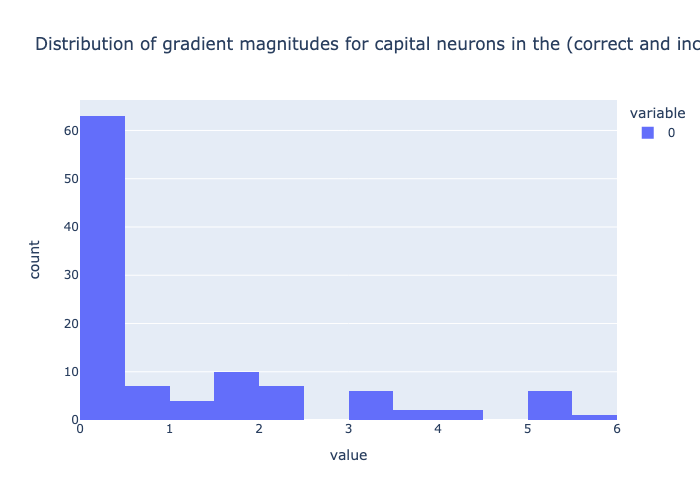

In [50]:
px.histogram(
    pd.concat([capital_neuron_df.loc[idx[neuron_slice], :] for neuron_slice in capital_neurons2()]).values,
    title="Distribution of gradient magnitudes for capital neurons in the (correct and incorrect) capitals dataset"
)

`W_out` updates are an order of magnitude smaller than `W_in` updates. (Why?)

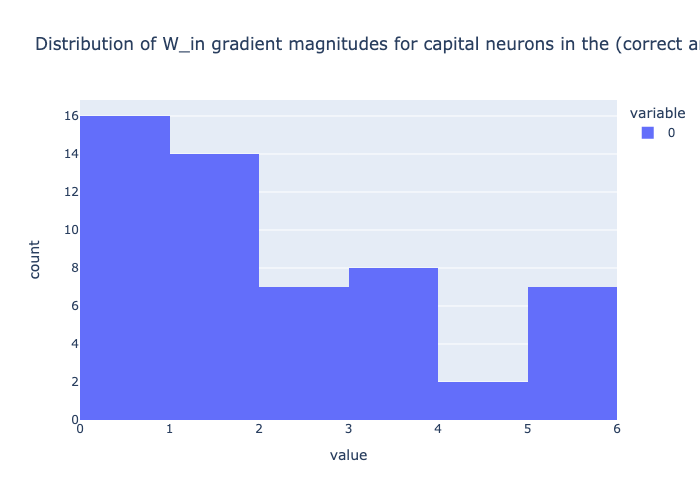

In [51]:
px.histogram(
    pd.concat([capital_neuron_df.loc[idx[neuron_slice], :] for neuron_slice in capital_neurons2(matrix="W_in")]).values,
    title="Distribution of W_in gradient magnitudes for capital neurons in the (correct and incorrect) capitals dataset"
)

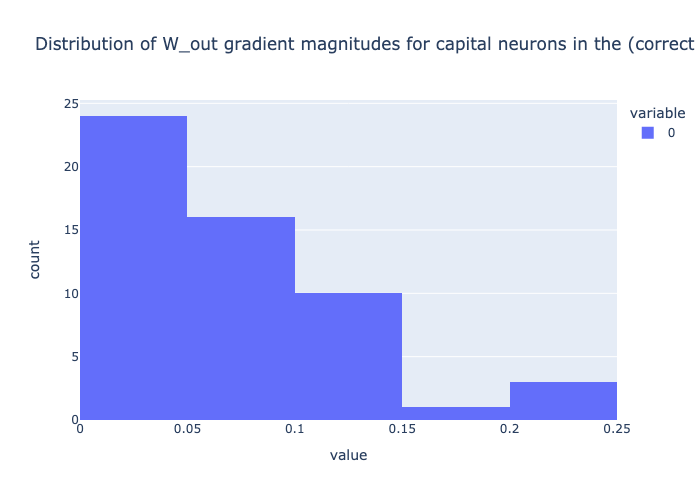

In [52]:
px.histogram(
    pd.concat([capital_neuron_df.loc[idx[neuron_slice], :] for neuron_slice in capital_neurons2(matrix="W_out")]).values,
    title="Distribution of W_out gradient magnitudes for capital neurons in the (correct and incorrect) capitals dataset"
)

In [53]:
pd.concat([capital_neuron_df.loc[idx[neuron_slice], :] for neuron_slice in capital_neurons2(correct=True, matrix="W_out")]) \
    .sort_values(by="Magnitude", ascending=False).head(10)

,,,,,Magnitude
Input,Correct,Matrix,Layer,Neuron,
The capital of Brazil is Brasilia.,True,W_out,4,1406,0.238261
The capital of Australia is Canberra.,True,W_out,4,1406,0.218975
The capital of South Africa is Pretoria.,True,W_out,4,1406,0.216853
The capital of Canada is Ottawa.,True,W_out,4,1406,0.176940
The capital of Russia is Moscow.,True,W_out,4,1406,0.146237
The capital of Mexico is Mexico City.,True,W_out,4,1406,0.126595
The capital of Brazil is Brasilia.,True,W_out,7,1137,0.122570
The capital of India is New Delhi.,True,W_out,4,1406,0.119972
The capital of South Africa is Pretoria.,True,W_out,7,1137,0.097468


In [54]:
pd.concat([capital_neuron_df.loc[idx[neuron_slice], :] for neuron_slice in capital_neurons2(correct=False, matrix="W_out")]) \
    .sort_values(by="Magnitude", ascending=False).head(10)

,,,,,Magnitude
Input,Correct,Matrix,Layer,Neuron,
The capital of India is Pretoria.,False,W_out,4,1406,0.132091
The capital of Russia is New Delhi.,False,W_out,4,1406,0.129557
The capital of Mexico is Canberra.,False,W_out,4,1406,0.127815
The capital of Canada is Brasilia.,False,W_out,4,1406,0.124469
The capital of Brazil is Ottawa.,False,W_out,4,1406,0.116335
The capital of Australia is Mexico City.,False,W_out,4,1406,0.106765
The capital of South Africa is Moscow.,False,W_out,4,1406,0.076342
The capital of Brazil is Ottawa.,False,W_out,7,1137,0.073566
The capital of Mexico is Canberra.,False,W_out,7,1137,0.068974


The capital neurons have significantly smaller updates on non-capital sentences.

In [55]:

pd.concat([verification_neuron_df.loc[idx[neuron_slice], :] for neuron_slice in capital_neurons()]) \
    .sort_values(by="Magnitude", ascending=False).head(10)

,,,,Magnitude
Input,Matrix,Layer,Neuron,
Google Authenticator is adding a long-standing customer request,W_in,8,1961,1.170218
Hillary Clinton: Republicans Are Playing Into the Hands of Putin and Xi,W_in,8,1961,1.133584
The quick brown fox jumps over the lazy dog.,W_in,8,1961,1.128265
"AGI ruin mostly rests on strong claims about alignment and deployment, not about society",W_in,8,1961,1.037483
Hillary Clinton: Republicans Are Playing Into the Hands of Putin and Xi,W_in,4,1406,0.926769
One apple plus one apple equals two apples.,W_in,8,1961,0.921822
The Brain is Not Close to Thermodynamic Limits on Computation,W_in,8,1961,0.685662
"Sir, in my heart there was a kind of fighting That would not let me sleep.",W_in,8,1961,0.619164
Google Authenticator is adding a long-standing customer request,W_in,4,1406,0.579521


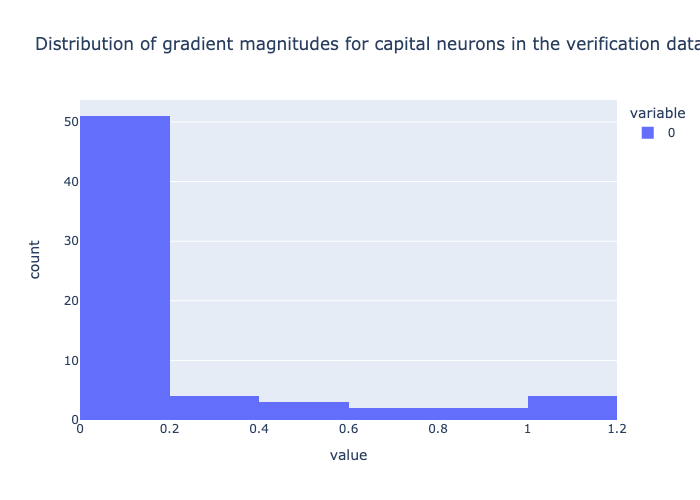

In [56]:
px.histogram(
    pd.concat([verification_neuron_df.loc[idx[neuron_slice], :] for neuron_slice in capital_neurons()]).values,
    title="Distribution of gradient magnitudes for capital neurons in the verification dataset (unrelated to capitals)"
)

## TODO

* Automate finding which neurons update for some sentences but not others, use this to find neurons which care about other cities or other concepts.
* Look at residual stream updates for other inputs